# Load Dependencies

## Install Libraries 

In [1]:
!pip install pandas --break-system-packages
!pip install librosa --break-system-packages
!pip install pyloudnorm --break-system-packages
!pip install tensorflow tensorflow-io --break-system-packages
!pip install pydub --break-system-packages

## Import Libaries

In [96]:
import os
import shutil
import uuid
import pandas as pd
import math
import numpy as np
from pydub import AudioSegment, silence
import librosa as lb
import warnings
import pyloudnorm as pyln
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_io as tfio

# Data Import

## File Paths

In [3]:
# return list of files for of given folder
def get_files(path: str, file_formats: list, exclude_dirs: list = []):
    filtered_files=[]
    for root, dirs, files in os.walk(path, topdown=True):
        if root not in exclude_dirs:
            for file in files:
                file_name, file_extension = os.path.splitext(file)
                if file_extension in file_formats:
                    file_path = root + "/" + file
                    filtered_files.append(file_path)
    return filtered_files

In [92]:
dir = "/home/helsfyr2_with_9_dbfs/"
neg_dir= "/home/helsfyr2_with_9_dbfs/neg"
file_formats= ['.wav']

pos_files = get_files(dir, file_formats, [neg_dir])
neg_files = get_files(neg_dir, file_formats)

del dir, neg_dir, file_formats

### Copy files in label folder structure

In [110]:
# for pos_file in pos_files:
#     file_name =  os.path.basename(pos_file)
#     shutil.copyfile(pos_file, '/home/data/announcement/' + file_name)

In [111]:
# for neg_file in neg_files:
#     file_name =  os.path.basename(neg_file)
#     shutil.copyfile(neg_file, '/home/data/no announcement/' + file_name)

# Data Preperation

## Audio normalization

In [5]:
target_sr: int = 16000
target_loudness: float = -12.0

In [6]:
def audio_normalization(y: np.ndarray, sr: int):
    #Convert to mono
    y = lb.to_mono(y=y)

    #set sampling rate
    y = lb.resample(y=y, orig_sr=sr, target_sr=target_sr)

    #Normalize loudness
    with warnings.catch_warnings(record=True):
        meter = pyln.Meter(rate=target_sr)
        loudness = meter.integrated_loudness(data=y)
        y = pyln.normalize.loudness(data=y, input_loudness=loudness, target_loudness=target_loudness)
    return y

## Mel diagram

In [7]:
def log_melspectogram(y: np.array, sr: int):
    y = audio_normalization(y=y, sr=sr)
    S = lb.feature.melspectrogram(y=y, sr=sr ,n_mels=128)
    return lb.power_to_db(S=S, ref=np.max)

In [8]:
def file_log_melspectograms(file_path:str, duration: float, offset: float):
    y, sr = lb.load(file_path)
    duration_total = lb.core.get_duration(y=y, sr=sr)
    S = []
    #Slicing
    for i in np.arange(0.0, duration_total-offset, offset):
        y = lb.load(file_path, mono=True, offset=i, duration=duration)[0]
        s=log_melspectogram(y=y, sr=sr)
        S.append(s)
    return np.array(S)

In [9]:
def files_log_melspectograms(file_paths:list, duration: float, offset: float):
    data_pos=[]
    for file_path in file_paths:
        for s in file_log_melspectograms(file_path=file_path, duration=duration, offset=offset):
            data_pos.append(s)
    return np.array(data_pos)

## Load data

In [10]:
def load_data_category(file_paths: list, label: str, duration:float, offset:float):
    data = files_log_melspectograms(file_paths=file_paths, duration=duration, offset=offset)
    label = np.array([label for i in range(len(data))])
    return data, label

In [11]:
#TODO  Iteration need to start from here
duration: float = 2.0

#TODO solve [src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (800) too large for available bit count (760)
pos_data, pos_label = load_data_category(file_paths=pos_files[:100], label='announcement', duration=duration, offset=duration)
neg_data, neg_label = load_data_category(file_paths=neg_files[:250], label='no announcement', duration=duration, offset=duration)

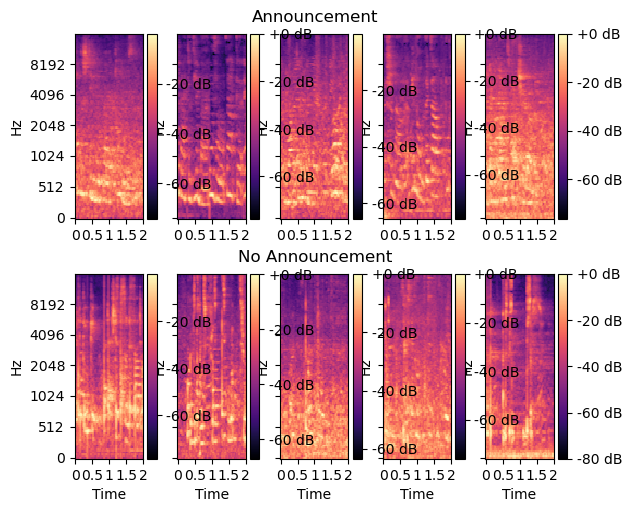

In [12]:
random.seed(42)
n=5

fig = plt.figure()
fig.suptitle('Figure title')
subfigs = fig.subfigures(nrows=2, ncols=1)
subfig_pos=subfigs[0]
subfig_neg=subfigs[1]
subfig_pos.suptitle('Announcement')
subfig_neg.suptitle('No Announcement')
axs_pos = subfig_pos.subplots(nrows=1, ncols=n, sharex=True, sharey= True)
axs_neg = subfig_neg.subplots(nrows=1, ncols=n, sharex=True, sharey= True)

for i in range(n):
    S_pos = random.choice(pos_data)
    S_neg = random.choice(neg_data)
    ax_pos = axs_pos[i]
    ax_neg = axs_neg[i]
    
    # Display spectrograms
    img_pos = lb.display.specshow(data=S_pos, x_axis='time', y_axis='mel', sr=target_sr, fmax=target_sr, ax=ax_pos)
    img_neg = lb.display.specshow(data=S_neg, x_axis='time', y_axis='mel', sr=target_sr, fmax=target_sr, ax=ax_neg)
    fig.colorbar(img_pos, ax=ax_pos, format='%+2.0f dB')
    fig.colorbar(img_neg, ax=ax_neg, format='%+2.0f dB')

plt.show()

#TODO save plot for each experiment

del n, fig, subfigs, subfig_pos, subfig_neg, axs_pos, axs_neg, i, S_pos, S_neg, ax_pos, ax_neg, img_pos, img_neg

In [36]:
#ensure that percentage of positive and negative data sets is maintained
pos_size = 0.5

data_size = 2 * np.min([math.floor(len(pos_data)*pos_size), len(neg_data)])
data_size_pos = math.ceil(data_size * pos_size)
data_size_neg = np.min([len(neg_data), data_size-data_size_pos])

np.random.seed(42)

def get_random_data_set(data: np.array, label: np.array, size: int):
    index = np.random.choice(data.shape[0], size, replace=False)
    return data[index], label[index]

#combine pos and neg data sets
data_pos_subset, label_pos_subset = get_random_data_set(data=pos_data, label=pos_label, size=data_size_pos)
data_neg_subset, label_neg_subset = get_random_data_set(data=neg_data, label=neg_label, size=data_size_neg)
data_subset = np.concatenate((data_pos_subset, data_neg_subset))
label_subset = np.concatenate((label_pos_subset, label_neg_subset))

del data_pos_subset, data_neg_subset, label_pos_subset, label_neg_subset, data_subset, label_subset

In [79]:
test_size = 0.25

#TODO generate training and test set
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=104,test_size=0.25, shuffle=True)
train = (X_train, y_train)
test = (X_test, y_test)

# Model

https://www.tensorflow.org/tutorials/images/cnn

In [116]:
#TODO set batchsize
# https://keras.io/api/data_loading/
data = tf.keras.utils.audio_dataset_from_directory('/home/data', output_sequence_length=duration) #TODO header is incorrect: Expected RIFF but found ID3
data_iterator = data.as_numpy_iterator()


Found 2776 files belonging to 2 classes.


In [113]:
batch = data_iterator.next()

2023-09-03 23:20:23.795013: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found ID3
2023-09-03 23:20:23.795116: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found ID3
2023-09-03 23:20:23.795157: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found ID3
2023-09-03 23:20:23.795207: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found ID3
2023-09-03 23:20:23.795256: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found ID3
2023-09-03 23:20:23.795564: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRE

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Header mismatch: Expected RIFF but found ID3
	 [[{{node DecodeWav}}]] [Op:IteratorGetNext] name: 

In [ ]:
#TODO data pre-processing: https://www.youtube.com/watch?v=jztwpsIzEGc&t=2002s


In [84]:
# Create neural network
input_shape = X_train.shape[1:]

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


ValueError: Input 0 of layer "conv2d_49" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 128, 63)

In [60]:
hist = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test))

Epoch 1/60


2023-09-03 21:37:04.467726: W tensorflow/core/framework/op_kernel.cc:1805] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to float is not supported


UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1193917/1744058394.py", line 1, in <module>
      hist = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1085, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1179, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/metrics/base_metric.py", line 708, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_1929]